# **OCR Model Training**




###**Installing and Importing Required Libraries**


---



1. OpenCV - Image Processing Library
2. Tensorflow 2.0 - Machine learning Library

In [0]:
!pip install tensorflow==2.0rc1

from IPython.display import clear_output
import cv2 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

clear_output()

###**Unzipping My DATASET**


---


This will create a data directory. The hierarchy of this directory as shown below:

          data --+-> letters --+--> a
                 +-> noise     +--> b
                 +-> number    ......

In [0]:
!unzip data.zip
clear_output()

###**Function to show image**


---


"imshow(image)" where image is np.array type representing image to show.

In [0]:
def imshow(image):
  plt.imshow(image, cmap = 'gray', interpolation = 'bicubic')
  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()

###**Mapping Letters classes to numbers**
Keywords contains letters with appropriate index number mapping

In [0]:
keywords = [chr(c) for c in range(ord('a'), ord('z')+1)]
cap = ['A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'Q', 'R', 'T']
keywords = keywords + cap
keywords = keywords + ['noise']

In [5]:
print(len(keywords))

41


###**Preparing Data for Training**

---



In [0]:
data_images = list()
labels = list()
i = 0
for c in keywords:
  path = 'data/{}/'.format(c)
  files = os.listdir(path)
  for name in files:
      img = cv2.imread(path+name)
      try:
        img = cv2.resize(img, (50, 50), interpolation = cv2.INTER_AREA)
      except:
        continue
      data_images.append(img)
      labels.append(i)
  i += 1


In [0]:
data_images = np.array(data_images)
labels = np.array(labels)

In [8]:
print(labels.shape, data_images.shape)

(23538,) (23538, 50, 50, 3)


###**Model Architecture**


---


Layer Sequence (Sequencial Model) : 


1.   Conv2D Layer
2.   Flatten Operation
3.   Dense Layer with 200 units
4.   Dense Layer with 41 units




In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = (50, 50, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(41)
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 200)               14745800  
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                8241      
Total params: 14,754,937
Trainable params: 14,754,937
Non-trainable params: 0
_________________________________________________________________


**Training starts with callback of early stopping with patience 2**

---



In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.fit(data_images, labels, epochs=10, callbacks = [callback])
clear_output()

Train on 23538 samples
Epoch 1/10
23538/23538 [==============================] - 128s 5ms/sample - loss: 37.6322 - accuracy: 0.8674
Epoch 2/10
23538/23538 [==============================] - 125s 5ms/sample - loss: 0.2132 - accuracy: 0.9564
Epoch 3/10
 5920/23538 [======>.......................] - ETA: 1:33 - loss: 0.1442 - accuracy: 0.9659

KeyboardInterrupt: ignored

In [14]:
test_loss, test_acc = model.evaluate(data_images,  labels, verbose=2)

print('\nTest accuracy:', test_acc)

23538/1 - 30s - loss: 0.0714 - accuracy: 0.9715

Test accuracy: 0.97145045




---


---





# **OCR Model Testing**


 

####**Adding Softmax Activation**

---



In [0]:
probablity = tf.keras.Sequential(
    model,
    tf.keras.layers.Softmax()
)

###**Creating Directory 'gen'**


---

'gen' directory is created with its sub directory for storing by machine identified data

In [0]:
!mkdir gen
for c in keywords:
  os.system('mkdir gen/'+c)

###**Saving the trained model**


---

'model' model is saved in current directory with name 'model.hd5'


In [0]:
model.save('model.h5')
clear_output()

In [0]:
model = tf.keras.models.load_model('model.h5')

### **OCR Deployment Demo (Testing Model)**


---



In [0]:
X = 0
Y = 1
POS = 1
SHAPE = 2
W = 0
H = 1

In [0]:
def check_in(c, region):
    x, y, w, h = region
    center_x = c[POS][X]+c[SHAPE][W]/2
    center_y = c[POS][Y]
    if (center_x > x-1 and center_x < x+w+1) and (center_y > y-1 and center_y < y+h+1):
        return True
    return False

In [0]:
def get_region(c, regions):
    for region in regions:
        if check_in(char, region):
          return region
    return False

#####***'sort_chars(line)'*** Function to sort characters in given line

In [0]:
def sort_chars(line):
  res = list()
  while len(line) > 0:
    mx = 100000
    m = 0
    for c in line:
      if c[POS][X] <= mx:
        mx = c[POS][X]
        m = c
    line.remove(m)
    res.append(m)
  return res

#####"***sort_lines_by_yval(lines)***" function sorts list of lines according to its y coordinate in image space

In [0]:
def sort_lines_by_yval(lines):
  res = list()
  while len(lines) > 0:
    mn = 100000
    m = 0
    for line in lines:
      if line[0][POS][Y] < mn:
        mn = line[0][POS][Y]
        m = line
    lines.remove(m)
    res.append(m)
  return res

#####"***arrangeline(characters)***" Function to group characters in given image by lines

In [0]:
def group_chars_by_line(characters):
  lines = list()
  linei = 0
  while len(characters) > 0:
      m = characters[0]
      my = m[1][1]
      my_plus_h = m[1][1]+m[2][1]
      lines.append([m])
      for c in characters[1:]:
          if my <= c[POS][Y]+c[SHAPE][H]/2 and c[POS][Y]+c[SHAPE][H]/2 <= my_plus_h:
              if my > c[POS][Y]:
                my = c[POS][Y]
              if my_plus_h < c[POS][Y]+c[SHAPE][H]:
                my_plus_h = c[POS][Y]+c[SHAPE][H]
              lines[linei].append(c)
              characters.remove(c)
      lines[linei]= sort_chars(lines[linei])
      linei += 1
      characters.remove(m)
  return lines

#####**Main Run Start Point**

****************************** Text in image 2.jpg ****************************** 



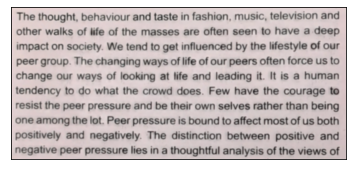

The thought behav our and taste  n fashlon muslc tegevls on and
other kalks of  lfe of the masses are often seen to have a deep
peer group mhe changlng kays of llfe ofour peersoften force us to
change our ways of looxlng at llfe and  eadlng lt  t ls a human
lendency to do what the crowd does Few have the courage to
reslsl the peer pressure and be thelr o n selves rather than belng
oneamong the  ot peer pressure ls bound toadTect most ofus both
posltlvely and negatlvely The dlstlnctlon be een posltlve and
negat ve peer pressure lles  n a thoughtful analysls of the vlews of
-------------------------------------------------------------------------------- 


****************************** Text in image 5.jpg ****************************** 



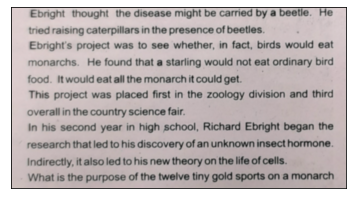

Ebnght thought the dlsease mlght be carned by a beetle ae
tned ralslng terplllars lnlhepresenceof beetles
Ebnght s pro ect was to see whether ln fact blrds would eat
monarchs Ee found that a starllng would not eat ordlnaw blrd
fooe It woule eat all themonarch  t couldget
Thls project was placed flrst ln the loology dlvlslon and thlrd
o erall  n thecount sclencefalr
ln dls second year ln hlgh chool Rlchard Ebrlght began the
research that lezdtohlsdlscove of an unxnownlnsect hormone
l ndlrectly It alsoled tohls newtheo on thellfeoF cells
wdat Is the purpose oF the twelve tlny gold spoas on a monarch
d
-------------------------------------------------------------------------------- 


****************************** Text in image 6.jpg ****************************** 



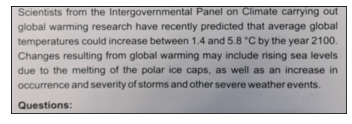

sclentlsts from the l ntergovernmental panel on cl l mate carwlng out
global warmlng research have recently predlctet that average global
temperatures coult l ncrease between a and b e oc by the year n oo
changes resultl ng from global warml ng mag l ncl ude rlsl ng sea levels
tue to the meltlng of the polar lce caps as well as an l ncrease l n
occurrence and severltgof storms and other severeweather events
oueselons
-------------------------------------------------------------------------------- 


****************************** Text in image 4.jpg ****************************** 



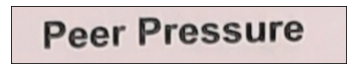

peer pressure
-------------------------------------------------------------------------------- 


****************************** Text in image 7.jpg ****************************** 



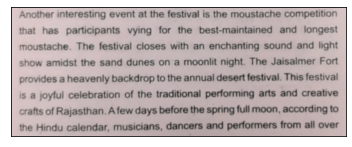

Another lnterestlng event at the festlval ls the moustache com et tlon
tdat has pahlclpants wlng for the best malntalned and longest
moestache The festlval closes wlth an enchantlng sound and llght
sdow amldst the sand dunes on a moonllt nlght The ealsalmer Foh
e henly bacxdrop to the annual deseatestlval Tdhls festlval
rovles a eav
s a loyful celebratlon of the tradltlonal pe ormlng aRs and creatlve
craFts of RaIasthan Afewdays before the sprlng full moon accordlng to
e Elndu calendar muslclans dancers and pe ormers from all over
-------------------------------------------------------------------------------- 


****************************** Text in image 3.jpg ****************************** 



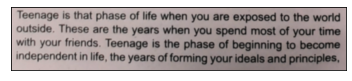

Teenage ls that phase of  lfe when you are egposed to the world
outside These are the years when you spend most of your tlme
lndependent  n  lfe the years oF formlng your  deals and pr nclples
-------------------------------------------------------------------------------- 


****************************** Text in image 1.jpg ****************************** 



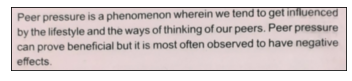

peer pressure  sa phenomenon whereln we tend toget lnnuenced
bythe lgtestyle and thewaysot thlnklng ofour peers peer pressure
n proue benewclal but  t ls most oTlen obse ed to have negatlve
efiects
-------------------------------------------------------------------------------- 




In [79]:
imgs = [f for f in os.listdir('.') if f.endswith('.jpg')]
img_no = 0
for img in imgs:
    avg_w = 0
    avg_h = 0
    character_list = list()
    img = cv2.imread(img)
    color = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.medianBlur(img,5)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,21,10)
    contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    img[:,:]=0
    i = 0
    for c in contours:
      try:
        x,y,w,h = cv2.boundingRect(c)
        try:
            show = color[y-2:y+h+2, x-2:x+w+2]
        except:
            show = color[y:y+h, x:x+w]
        test_data = cv2.resize(show,(50,50),interpolation = cv2.INTER_AREA)
        test_data=np.array([test_data])
        cmd = np.argmax(probablity.predict(test_data))
        if cmd < 40:
          avg_w += w
          avg_h += h
          cv2.rectangle(img, (x,y), (x+w+w//3, y+h), 255, -1)
          character_list.append([keywords[cmd], (x,y), (w,h)])
          i+= 1
        #cv2.imwrite('gen/'+keywords[cmd]+'/'+str(i)+'.jpg', show)
        #i+=1
      except:
            continue
    avg_w/=i
    avg_h/=i
    text = group_chars_by_line(character_list)#, img)
    text = sort_lines_by_yval(text)
    print('*'*30, 'Text in image', imgs[img_no], '*'*30,'\n')
    imshow(color)

    img = cv2.blur(img,(8,1))
    ret, img = cv2.threshold(img,254,255,cv2.THRESH_BINARY)
    kernel = np.ones((3,10),np.uint8)
    contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    regions = list()
    for cnt in contours:
      region = cv2.boundingRect(cnt)
      if region[3] <= avg_h*7:
        regions.append(region)
    del contours
    for l in text:
      char = l[0]
      region = get_region(char, regions)
      if not region:
        continue
      for char in l:
        if not check_in(char, region):
          print(end=' ')
          r = get_region(char, regions)
          if not r:
            continue
          region = r
        print(char[0], end='')
      print()
    print('-'*80, '\n\n')
    img_no += 1

###**Packing Generated Data for further checking by human**

---



In [0]:
!tar cf gen.tar gen
clear_output()

###**Watching the model test results**


---



In [0]:
for c in keywords:
  path='gen/{}/'.format(c)
  files = os.listdir(path)
  for img in files[:2]:
    img=cv2.imread(path+img,0)
    imshow(img)
    print(' '*10, c)